In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing Packages

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import tensorflow as tf

from losses import customLoss
from ploting import plotGeneratedImagesUNS, plotLossUNS
from saving import saveModels
from loadData import loadData

Using TensorFlow backend.


In [3]:
import warnings
#warnings.filterwarnings("ignore")

In [4]:
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 20

In [5]:
# Load UNS Data
X_train, Y_train, X_test, Y_test = loadData(nrows=100000)

/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/peseux/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/peseux/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
from sklearn.svm import SVC as SVC
clf = SVC(gamma='scale', decision_function_shape='ovo', kernel="poly")
clf.fit(X_train, Y_train)

/home/peseux/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
clf.decision_function(X_test)
sess = tf.Session()
tensor = tf.constant([float(i) for i in range(25)]).eval(session=sess)
clf.decision_function([tensor])

array([-24773.89899791])

In [8]:
data_shape = X_train.shape

In [9]:
X_train = X_train.values

In [10]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(data_shape[1], activation='tanh'))
generator.compile(loss="binary_crossentropy", optimizer=adam)
# generator.compile(loss='binary_crossentropy', optimizer=adam)

In [12]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=data_shape[1], kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
X = np.zeros([157, 128])
Y = np.zeros([157], dtype=np.int32)
example_id = np.array(['%d' % i for i in range(len(Y))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=128),),
    l2_regularization=0.1)

svm.fit(input_fn=train_input_fn, steps=10)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8d94493668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fr

SVM(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinarySvmHead object at 0x7f8dbbb47c18>, 'feature_columns': (_RealValuedColumn(column_name='x', dimension=128, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': <tensorflow.contrib.linear_optimizer.python.sdca_optimizer.SDCAOptimizer object at 0x7f8dbbd9fcc0>, 'weight_column_name': None, 'update_weights_hook': <tensorflow.contrib.learn.python.learn.estimators.linear._SdcaUpdateWeightsHook object at 0x7f8dbbb46860>})

In [43]:
# Custom Loss
def customLoss(layer_weights, lamda, alpha=1, y_func="pow10"):
    def lossFunction(y_true,y_pred):
        y = - K.log(y_pred)
        x = clf.decision_function([layer_weights.eval(session=sess)])[0]# (K.mean(K.abs(( - layer_weights + 1)/2)))#/2)) + 0.5*K.std(layer_weights)) / 2
        if y_func == "carre":
            fy = y*y
        elif y_func == "pow10":
            fy = y**10
        else:
            fy = y
        #loss = x * K.log( - K.abs(y_pred - y_true)) + (1 - x)*(K.log( - K.abs(y_pred - y_true))*K.log( - K.abs(y_pred - y_true)))
        loss = y + lamda * x 
        return  loss

    return lossFunction

In [44]:
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
lamda= .05
gan.compile(loss=customLoss(x, lamda), optimizer =adam)

FailedPreconditionError: Attempting to use uninitialized value dense_4/kernel
	 [[node dense_4/kernel/read (defined at /home/peseux/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402) ]]

Caused by op 'dense_4/kernel/read', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/peseux/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/peseux/.local/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/peseux/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-92d42ff0d97d>", line 8, in <module>
    generator.add(Dense(data_shape[1], activation='tanh'))
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/engine/sequential.py", line 181, in add
    output_tensor = layer(self.outputs[0])
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/layers/core.py", line 866, in build
    constraint=self.kernel_constraint)
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/home/peseux/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/peseux/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_4/kernel
	 [[node dense_4/kernel/read (defined at /home/peseux/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402) ]]


In [29]:
dLosses = []
gLosses = []
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise, verbose=False)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)


        if e == 1 or e % 20 == 0:
            pass
            #saveModels(e, generator=generator, discriminator=discriminator)
            #plotGeneratedImagesUNS(e, generator=generator, randomDim=randomDim)
    # Plot losses from every epoch
    plotLossUNS(e, dLosses, gLosses)

  0%|          | 0/558 [00:00<?, ?it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 558.9453125
--------------- Epoch 1 ---------------


  0%|          | 2/558 [00:00<00:41, 13.34it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/558 [00:00<00:44, 12.39it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/558 [00:00<00:37, 14.84it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/558 [00:00<00:41, 13.39it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/558 [00:00<00:40, 13.63it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/558 [00:00<00:40, 13.68it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/558 [00:00<00:23, 23.81it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/558 [00:00<00:41, 13.29it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/558 [00:00<00:47, 11.80it/s]

--------------- Epoch 10 ---------------


100%|██████████| 558/558 [00:44<00:00, 12.72it/s]


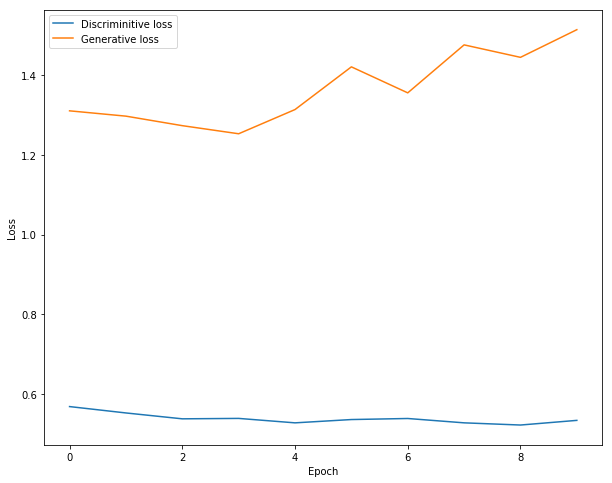

In [30]:
epochs = 10
batchSize = 128

train(epochs=epochs, batchSize=batchSize)

In [50]:
X_train[:15].shape

(15, 25)